# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


In [118]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
import category_encoders as ce #кодирование данных
%matplotlib inline

In [99]:
#Чтение таблицы
churn_data = pd.read_csv('ML-3_churn.zip')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [100]:
data = churn_data.copy()

* RowNumber — номер строки таблицы;
* CustomerId — идентификатор клиента;
* Surname — фамилия клиента;
* CreditScore — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и возвращал их);
* Geography — страна проживания клиента (банк межнациональный);
* Gender — пол клиента;
* Age — возраст клиента;
* Tenure — сколько лет клиент пользуется банком;
* Balance — сколько у клиента денег на счетах в банке;
* NumOfProduct — число услуг банка, которыми воспользовался клиент;
* HasCrCard — есть ли у клиента кредитная карта (1 — да, 0 — нет);
* IsActiveMember — есть ли у клиента статус «активный клиент» (1 — да, 0 — нет);
* EstimatedSalary — предполагаемая заработная плата клиента;
* Exited — статус ушедшего (1 — ушедший клиент, 0 — лояльный клиент).

## Практика: логистическая регрессия

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

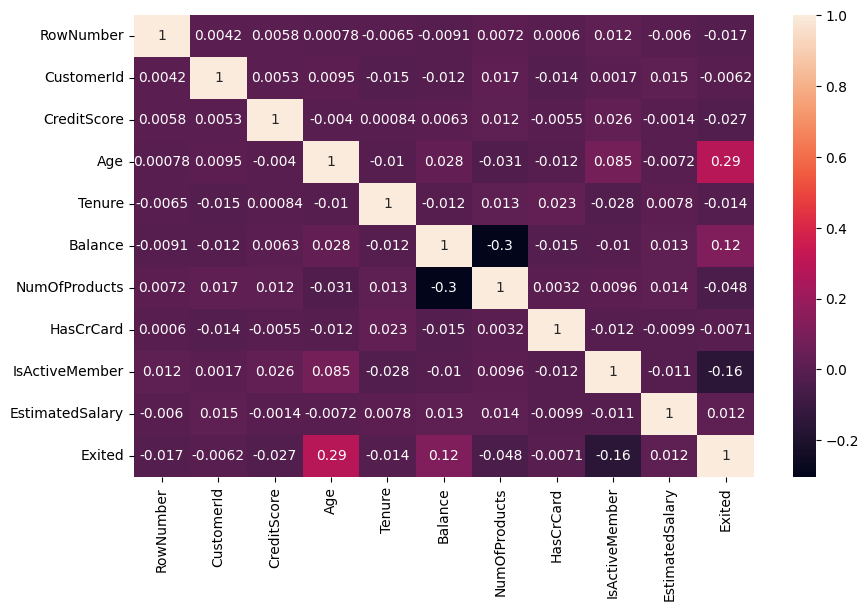

In [101]:
# посмотрим на корреляцию признаков
fig, ax = plt.subplots(figsize = (10, 6))
sns.heatmap(churn_data.corr(numeric_only=True), annot=True);

c:\Users\dasad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


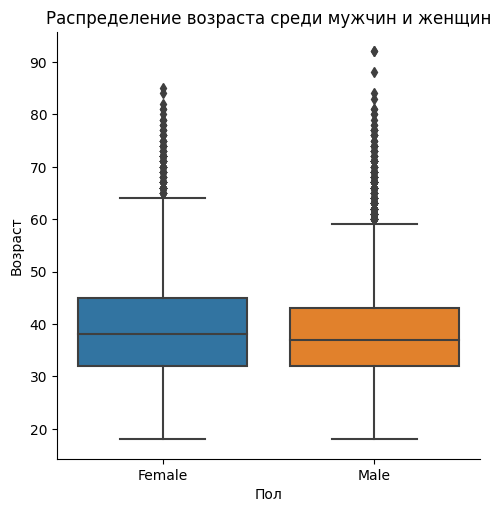

In [102]:
sns.catplot(data = data, x = 'Gender', y = 'Age', kind='box')
plt.title('Распределение возраста среди мужчин и женщин')
plt.xlabel('Пол')
plt.ylabel('Возраст')
plt.show()

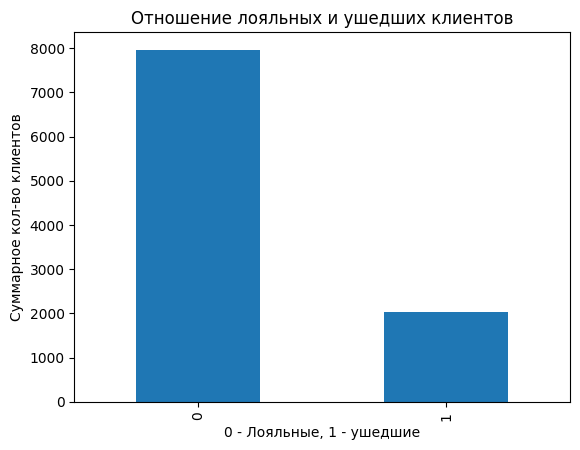

In [103]:
counts_c = churn_data['Exited'].value_counts()

counts_c.plot(kind='bar')
plt.xlabel('0 - Лояльные, 1 - ушедшие')
plt.ylabel('Суммарное кол-во клиентов')
plt.title('Отношение лояльных и ушедших клиентов')
plt.show()

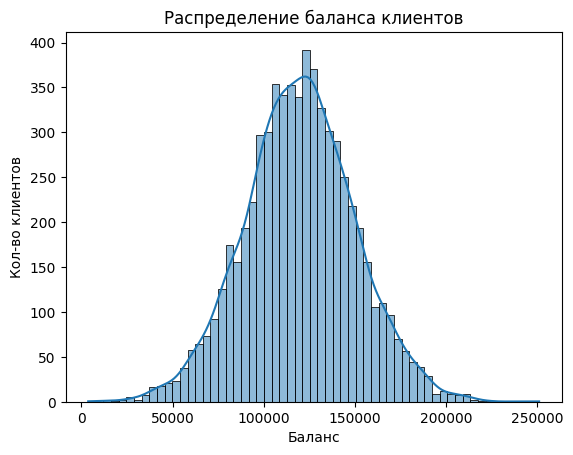

In [104]:
sns.histplot(data =data[data['Balance'] > 2500], x = 'Balance', kde=True)
plt.xlabel('Баланс')
plt.ylabel('Кол-во клиентов')
plt.title('Распределение баланса клиентов')
plt.show()

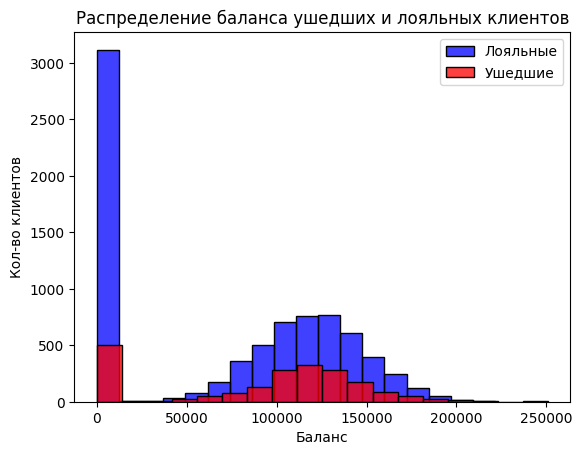

In [105]:
sns.histplot(data= data[data['Exited'] == 0], x = 'Balance', color='Blue', label = 'Лояльные')
sns.histplot(data=data[data['Exited'] == 1], x = 'Balance', color='Red', label='Ушедшие')

plt.xlabel('Баланс')
plt.ylabel('Кол-во клиентов')
plt.title('Распределение баланса ушедших и лояльных клиентов')
plt.legend()
plt.show()

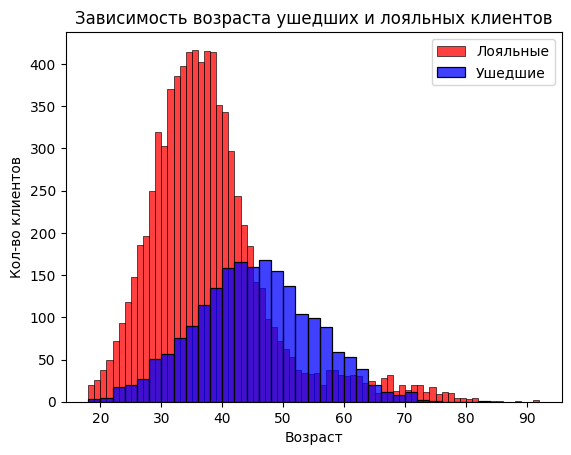

In [106]:
sns.histplot(data=data[data['Exited'] == 0], x='Age', color = 'Red', label='Лояльные')
sns.histplot(data=data[data['Exited'] == 1], x='Age', color = 'Blue', label='Ушедшие')

plt.xlabel('Возраст')
plt.ylabel('Кол-во клиентов')
plt.title("Зависимость возраста ушедших и лояльных клиентов")
plt.legend()
plt.show()

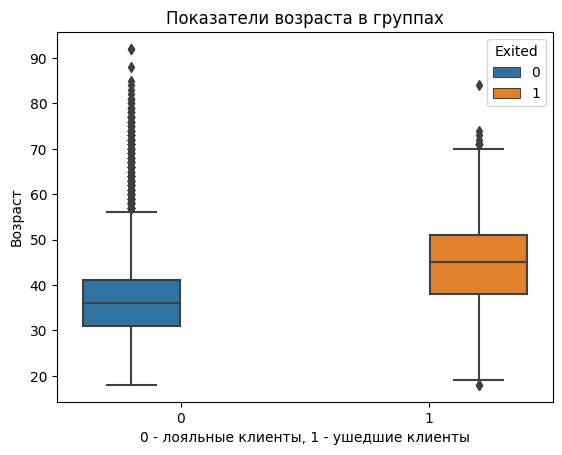

In [107]:
sns.boxplot(data=data, x='Exited', y="Age", hue='Exited')
plt.xlabel('0 - лояльные клиенты, 1 - ушедшие клиенты')
plt.ylabel('Возраст')
plt.title('Показатели возраста в группах')
plt.show()

В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [108]:
data = data[data['Geography'] == 'Germany']
data.shape

(2509, 14)

Избавление от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [109]:
data = data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


In [110]:
#Проверка данных на пропуски.
data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [111]:
#Проверка данных на дубликаты.
data[data.duplicated()].sum()

CreditScore          0
Gender               0
Age                  0
Tenure               0
Balance            0.0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary    0.0
Exited               0
dtype: object

### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [112]:
data['BalanceSalaryRatio'] = data['Balance']/data['EstimatedSalary']
data['BalanceSalaryRatio']

7        0.963969
15       2.225020
16      26.012449
26       0.804599
28       1.410850
          ...    
9982     1.191050
9984     1.752620
9986     5.391859
9990     0.652478
9998     0.808230
Name: BalanceSalaryRatio, Length: 2509, dtype: float64

In [113]:
data['Tenure'] = data['Tenure'].replace(0,1)
data['TenureByAge'] = data['Age'] / data['Tenure']
data['TenureByAge']

7        7.250000
15      15.000000
16      58.000000
26      18.000000
28      14.333333
          ...    
9982     6.571429
9984     5.000000
9986    47.000000
9990    11.000000
9998    14.000000
Name: TenureByAge, Length: 2509, dtype: float64

In [114]:
data['CreditScoreGivenAge'] = data['CreditScore'] / data['Age']
data['CreditScoreGivenAge']

7       12.965517
15      13.688889
16      11.258621
26      21.000000
28      13.348837
          ...    
9982    14.239130
9984    17.200000
9986    14.319149
9990    21.636364
9998    18.380952
Name: CreditScoreGivenAge, Length: 2509, dtype: float64

In [115]:
#One-Hot Encoding для признака "Gender"
data_dummies = pd.get_dummies( data, columns =['Gender'], dtype = 'int')
data_dummies

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_Female,Gender_Male
7,376,29,4,115046.74,4,1,0,119346.88,1,0.963969,7.250000,12.965517,1,0
15,616,45,3,143129.41,2,0,1,64327.26,0,2.225020,15.000000,13.688889,0,1
16,653,58,1,132602.88,1,1,0,5097.67,1,26.012449,58.000000,11.258621,0,1
26,756,36,2,136815.64,1,1,1,170041.95,0,0.804599,18.000000,21.000000,0,1
28,574,43,3,141349.43,1,1,1,100187.43,0,1.410850,14.333333,13.348837,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9982,655,46,7,137145.12,1,1,0,115146.40,1,1.191050,6.571429,14.239130,1,0
9984,602,35,7,90602.42,2,1,1,51695.41,0,1.752620,5.000000,17.200000,0,1
9986,673,47,1,183579.54,2,0,1,34047.54,0,5.391859,47.000000,14.319149,0,1
9990,714,33,3,35016.60,1,1,0,53667.08,0,0.652478,11.000000,21.636364,0,1


In [116]:
data = data_dummies.copy()

In [120]:
#Перекодирование признака "Tenure" с помощью One-Hot Encoding
encoder = preprocessing.OneHotEncoder
data = pd.get_dummies(data, columns = ['Tenure'], dtype  = 'int')
data

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,...,Tenure_1,Tenure_2,Tenure_3,Tenure_4,Tenure_5,Tenure_6,Tenure_7,Tenure_8,Tenure_9,Tenure_10
7,376,29,115046.74,4,1,0,119346.88,1,0.963969,7.250000,...,0,0,0,1,0,0,0,0,0,0
15,616,45,143129.41,2,0,1,64327.26,0,2.225020,15.000000,...,0,0,1,0,0,0,0,0,0,0
16,653,58,132602.88,1,1,0,5097.67,1,26.012449,58.000000,...,1,0,0,0,0,0,0,0,0,0
26,756,36,136815.64,1,1,1,170041.95,0,0.804599,18.000000,...,0,1,0,0,0,0,0,0,0,0
28,574,43,141349.43,1,1,1,100187.43,0,1.410850,14.333333,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9982,655,46,137145.12,1,1,0,115146.40,1,1.191050,6.571429,...,0,0,0,0,0,0,1,0,0,0
9984,602,35,90602.42,2,1,1,51695.41,0,1.752620,5.000000,...,0,0,0,0,0,0,1,0,0,0
9986,673,47,183579.54,2,0,1,34047.54,0,5.391859,47.000000,...,1,0,0,0,0,0,0,0,0,0
9990,714,33,35016.60,1,1,0,53667.08,0,0.652478,11.000000,...,0,0,1,0,0,0,0,0,0,0


In [121]:
#Перекодирование признака "NumOfProducts" с помощью One-Hot Encoding
data = pd.get_dummies(data, columns = ['NumOfProducts'], dtype = 'int')
data

,CreditScore,Age,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,...,Tenure_5,Tenure_6,Tenure_7,Tenure_8,Tenure_9,Tenure_10,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
7,376,29,115046.74,1,0,119346.88,1,0.963969,7.250000,12.965517,...,0,0,0,0,0,0,0,0,0,1
15,616,45,143129.41,0,1,64327.26,0,2.225020,15.000000,13.688889,...,0,0,0,0,0,0,0,1,0,0
16,653,58,132602.88,1,0,5097.67,1,26.012449,58.000000,11.258621,...,0,0,0,0,0,0,1,0,0,0
26,756,36,136815.64,1,1,170041.95,0,0.804599,18.000000,21.000000,...,0,0,0,0,0,0,1,0,0,0
28,574,43,141349.43,1,1,100187.43,0,1.410850,14.333333,13.348837,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9982,655,46,137145.12,1,0,115146.40,1,1.191050,6.571429,14.239130,...,0,0,1,0,0,0,1,0,0,0
9984,602,35,90602.42,1,1,51695.41,0,1.752620,5.000000,17.200000,...,0,0,1,0,0,0,0,1,0,0
9986,673,47,183579.54,0,1,34047.54,0,5.391859,47.000000,14.319149,...,0,0,0,0,0,0,0,1,0,0
9990,714,33,35016.60,1,0,53667.08,0,0.652478,11.000000,21.636364,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2509 entries, 7 to 9998
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CreditScore          2509 non-null   int64  
 1   Age                  2509 non-null   int64  
 2   Balance              2509 non-null   float64
 3   HasCrCard            2509 non-null   int64  
 4   IsActiveMember       2509 non-null   int64  
 5   EstimatedSalary      2509 non-null   float64
 6   Exited               2509 non-null   int64  
 7   BalanceSalaryRatio   2509 non-null   float64
 8   TenureByAge          2509 non-null   float64
 9   CreditScoreGivenAge  2509 non-null   float64
 10  Gender_Female        2509 non-null   int32  
 11  Gender_Male          2509 non-null   int32  
 12  Tenure_1             2509 non-null   int32  
 13  Tenure_2             2509 non-null   int32  
 14  Tenure_3             2509 non-null   int32  
 15  Tenure_4             2509 non-null   int32 

In [122]:
data.describe()

,CreditScore,Age,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,...,Tenure_5,Tenure_6,Tenure_7,Tenure_8,Tenure_9,Tenure_10,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
count,2509.000000,2509.000000,2509.000000,2509.00000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,...,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000
mean,651.453567,39.771622,119730.116134,0.71383,0.497409,101113.435102,0.324432,9.024870,13.451405,17.526487,...,0.103228,0.090474,0.089677,0.105221,0.107214,0.051016,0.537664,0.414508,0.038262,0.009566
std,98.168937,10.519143,27022.006157,0.45206,0.500093,58263.011501,0.468256,214.286020,12.833879,5.349558,...,0.304318,0.286917,0.285776,0.306899,0.309447,0.220075,0.498679,0.492735,0.191867,0.097354
min,350.000000,18.000000,27288.430000,0.00000,0.000000,11.580000,0.000000,0.192582,2.000000,6.112676,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,32.000000,102800.720000,0.00000,0.000000,51016.020000,0.000000,0.783284,5.000000,13.686275,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,651.000000,38.000000,119703.100000,1.00000,0.000000,102397.220000,0.000000,1.197220,8.000000,16.857143,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,722.000000,45.000000,137560.380000,1.00000,1.000000,151083.800000,1.000000,2.400083,16.500000,20.852941,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,850.000000,84.000000,214346.960000,1.00000,1.000000,199970.740000,1.000000,10614.655440,75.000000,46.388889,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [123]:
X = data.drop("Exited", axis=1)
y = data["Exited"]


Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [124]:
y.value_counts(normalize=True)

Exited
0    0.675568
1    0.324432
Name: proportion, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [125]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 25)
Test shape: (628, 25)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [126]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


Exited
0    0.675704
1    0.324296
Name: proportion, dtype: float64



Test :


Exited
0    0.675159
1    0.324841
Name: proportion, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [127]:
#Скалирование признаков
r_scaler = preprocessing.RobustScaler()

#Производим нормализацию
X_train_scaled = r_scaler.fit_transform(X_train)
X_test_scaled = r_scaler.transform(X_test)
#Составляем DataFrame из результата
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [128]:
#Проверка данных после преобразования признаков в тренировочном наборе данных
X_train_scaled.describe()

,CreditScore,Age,Balance,HasCrCard,IsActiveMember,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_Female,...,Tenure_5,Tenure_6,Tenure_7,Tenure_8,Tenure_9,Tenure_10,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
count,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,...,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000
mean,0.012740,0.131681,0.003964,-0.298246,-0.499734,-0.012129,5.099779,0.512675,0.092543,0.474216,...,0.110579,0.095694,0.088251,0.103137,0.111643,0.049442,-0.458799,0.412015,0.039872,0.006911
std,0.701485,0.818003,0.781644,0.457610,0.500133,0.570277,148.260267,1.205055,0.755169,0.499468,...,0.313694,0.294249,0.283735,0.304218,0.315010,0.216846,0.498432,0.492329,0.195711,0.082868
min,-2.165468,-1.538462,-2.652787,-1.000000,-1.000000,-0.991556,-0.606932,-0.552381,-1.499697,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
25%,-0.474820,-0.461538,-0.484923,-1.000000,-1.000000,-0.509202,-0.251494,-0.266667,-0.450218,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.525180,0.538462,0.515077,0.000000,0.000000,0.490798,0.748506,0.733333,0.549782,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.431655,3.538462,2.719426,0.000000,0.000000,0.944361,6418.868636,6.400000,4.118311,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000


In [129]:
#Проверка данных после преобразования признаков в тестовом наборе данных
X_test_scaled.describe()

,CreditScore,Age,Balance,HasCrCard,IsActiveMember,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_Female,...,Tenure_5,Tenure_6,Tenure_7,Tenure_8,Tenure_9,Tenure_10,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
count,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,...,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000
mean,-0.025123,0.150049,-0.003545,-0.250000,-0.511146,-0.014538,3.641247,0.614769,0.045015,0.479299,...,0.081210,0.074841,0.093949,0.111465,0.093949,0.055732,-0.472930,0.421975,0.033439,0.017516
std,0.720159,0.782570,0.759660,0.433358,0.500274,0.545527,35.662294,1.270368,0.727044,0.499970,...,0.273375,0.263344,0.291990,0.314958,0.291990,0.229587,0.499665,0.494268,0.179925,0.131288
min,-2.158273,-1.538462,-2.415525,-1.000000,-1.000000,-0.990780,-0.546627,-0.541799,-1.516072,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
25%,-0.483813,-0.461538,-0.463449,-0.250000,-1.000000,-0.460088,-0.244453,-0.251361,-0.478626,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
50%,-0.025180,0.076923,0.016993,0.000000,-1.000000,-0.001332,0.010448,0.050794,-0.065642,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.469424,0.615385,0.509265,0.000000,0.000000,0.438795,0.600258,0.983333,0.521854,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.431655,3.076923,2.504657,0.000000,0.000000,0.937616,801.284622,5.923810,3.278949,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000


Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


> Необходимо использовать F1- метрику, т.к. она балансирует между ложноположительными и ложноотрицательными результатами, что важно в этой задаче, т.к. банк не хочет терять клиентов, но и не обладает большим кол-вом средств, чтобы тратить их на тех кто уходить не собирался (ложноположительный резльтат).

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

> Необходимо добиться баланса между точностью и полнотой. Точность покажет нам, насколько вероятно клиент который собирается покинуть банк, действительно собирается это сдлеать и ему нужно предложить специальные условия. Если модель будет иметь высокую полноту, то мы с большей вероятностью не упустим клиента, который собирался "покинуть" банк. Поэтому метрика F1 подходит наилучшим образом.

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [130]:
log_reg = linear_model.LogisticRegression(random_state=41)
log_reg.fit(X_train_scaled, y_train)


y_train_pred = log_reg.predict(X_train_scaled)

print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = log_reg.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1271
           1       0.69      0.58      0.63       610

    accuracy                           0.78      1881
   macro avg       0.75      0.73      0.74      1881
weighted avg       0.77      0.78      0.78      1881

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       424
           1       0.68      0.55      0.61       204

    accuracy                           0.77       628
   macro avg       0.74      0.71      0.72       628
weighted avg       0.76      0.77      0.76       628



c:\Users\dasad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


> Метрика F1 показывает, что модель имеет более высокие метрики на тренировочной модели, нежели на тестовой. Можно заключить, что модель переобучена и не видит закономерностей на тестовой выборке.

In [131]:
log_reg = linear_model.LogisticRegression(random_state=41, penalty = 'l2', C = 4)
log_reg.fit(X_train_scaled, y_train)


y_train_pred = log_reg.predict(X_train_scaled)

print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = log_reg.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1271
           1       0.69      0.59      0.63       610

    accuracy                           0.78      1881
   macro avg       0.75      0.73      0.74      1881
weighted avg       0.77      0.78      0.78      1881

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       424
           1       0.68      0.56      0.62       204

    accuracy                           0.77       628
   macro avg       0.74      0.72      0.73       628
weighted avg       0.77      0.77      0.77       628



c:\Users\dasad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [132]:
log_reg = linear_model.LogisticRegression(random_state=41, penalty = 'l2', C = 10)
log_reg.fit(X_train_scaled, y_train)


y_train_pred = log_reg.predict(X_train_scaled)

print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = log_reg.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.84      1271
           1       0.70      0.59      0.64       610

    accuracy                           0.78      1881
   macro avg       0.76      0.73      0.74      1881
weighted avg       0.78      0.78      0.78      1881

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       424
           1       0.68      0.56      0.61       204

    accuracy                           0.77       628
   macro avg       0.74      0.72      0.73       628
weighted avg       0.77      0.77      0.77       628



c:\Users\dasad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


> При выборе L2-регуляризации и манипуляциях с коэффициентом С, значения практически не меняются.

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [133]:
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)


lr_model_poly = linear_model.LogisticRegression(random_state = 42)

lr_model_poly.fit(X_train_poly, y_train)

y_train_predict_poly = lr_model_poly.predict(X_train_poly)

y_test_predict_poly = lr_model_poly.predict(X_test_poly)
 
#Рассчитываем коэффициент детерминации для двух выборок
print("Train F1: {:.3f}".format(metrics.f1_score(y_train, y_train_predict_poly)))
print("Test F1: {:.3f}".format(metrics.f1_score(y_test, y_test_predict_poly)))

Train F1: 0.405
Test F1: 0.403


c:\Users\dasad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


> Исходя из полученных данных метрики, модель недообучена и не видит достаточного кол-ва закономерностей в данных. Значение метрики в тренировочном наборе чуть выше.

In [134]:
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)


lr_model_poly = linear_model.LogisticRegression(random_state= 42, penalty = None)

lr_model_poly.fit(X_train_poly, y_train)

y_train_predict_poly = lr_model_poly.predict(X_train_poly)

y_test_predict_poly = lr_model_poly.predict(X_test_poly)
 
#Рассчитываем коэффициент детерминации для двух выборок
print("Train F1: {:.3f}".format(metrics.f1_score(y_train, y_train_predict_poly)))
print("Test F1: {:.3f}".format(metrics.f1_score(y_test, y_test_predict_poly)))

Train F1: 0.405
Test F1: 0.403


c:\Users\dasad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


> В случае, если пар-р 'penalty' установлен на None, метрика показывает более лучший результат.

In [135]:
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)


lr_model_poly = linear_model.LogisticRegression(random_state= 42, penalty = 'l2', C = 10 )

lr_model_poly.fit(X_train_poly, y_train)

y_train_predict_poly = lr_model_poly.predict(X_train_poly)

y_test_predict_poly = lr_model_poly.predict(X_test_poly)
 
#Рассчитываем коэффициент детерминации для двух выборок
print("Train F1: {:.3f}".format(metrics.f1_score(y_train, y_train_predict_poly)))
print("Test F1: {:.3f}".format(metrics.f1_score(y_test, y_test_predict_poly)))

Train F1: 0.404
Test F1: 0.395


> При использовании L2- регуляризации и увеличении коэффициента С, метрика показывает более низки результат. При С > 10 метрика начинает снижаться.

### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

c:\Users\dasad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dasad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dasad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dasad\AppData\Local

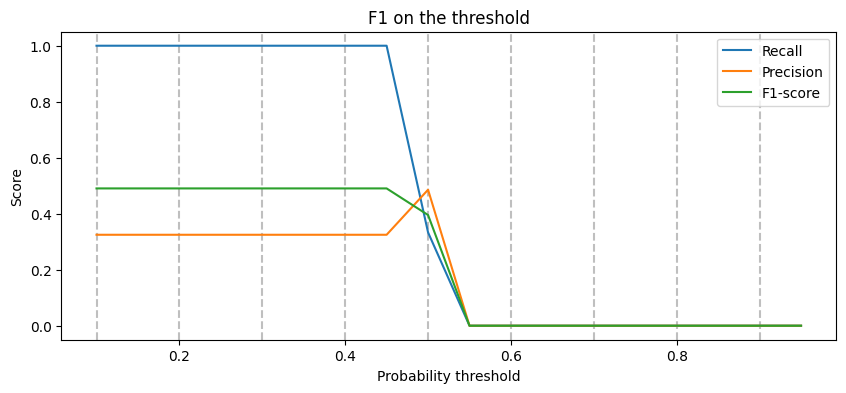

In [137]:
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(lr_model_poly.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
recall_scores = []
precision_scores = []
f1_scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    recall_scores.append(metrics.recall_score(y_test, y_test_pred_poly))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred_poly))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred_poly))
    
    #Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
for i in range(1, 10):
    ax.axvline(x=i/10, color='gray', linestyle='--', alpha=0.5)
ax.plot(thresholds, recall_scores, label='Recall')
ax.plot(thresholds, precision_scores, label='Precision')
ax.plot(thresholds, f1_scores, label='F1-score') 
ax.set_title('F1 on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend()

plt.show()

> Исходя из графика, можно сделать вывод, что максимальный показатель f1_score находиться в точке 0.0 - 0.45. Пересечение всех графиков, примерно на 0.51.


## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [138]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 25)
Test shape: (628, 25)


Импортируем необходимые для выполнения практики модули:

In [139]:
from sklearn import tree
from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [140]:
#Параметры модели леса
dt_clf_2d = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state = 42   
)
#Обучение модели на тренировочных данных
dt_clf_2d.fit(X_train, y_train)
#Предсказание
y_pred = dt_clf_2d.predict(X_train)
#Вывод метрик
print(metrics.classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1271
           1       1.00      1.00      1.00       610

    accuracy                           1.00      1881
   macro avg       1.00      1.00      1.00      1881
weighted avg       1.00      1.00      1.00      1881



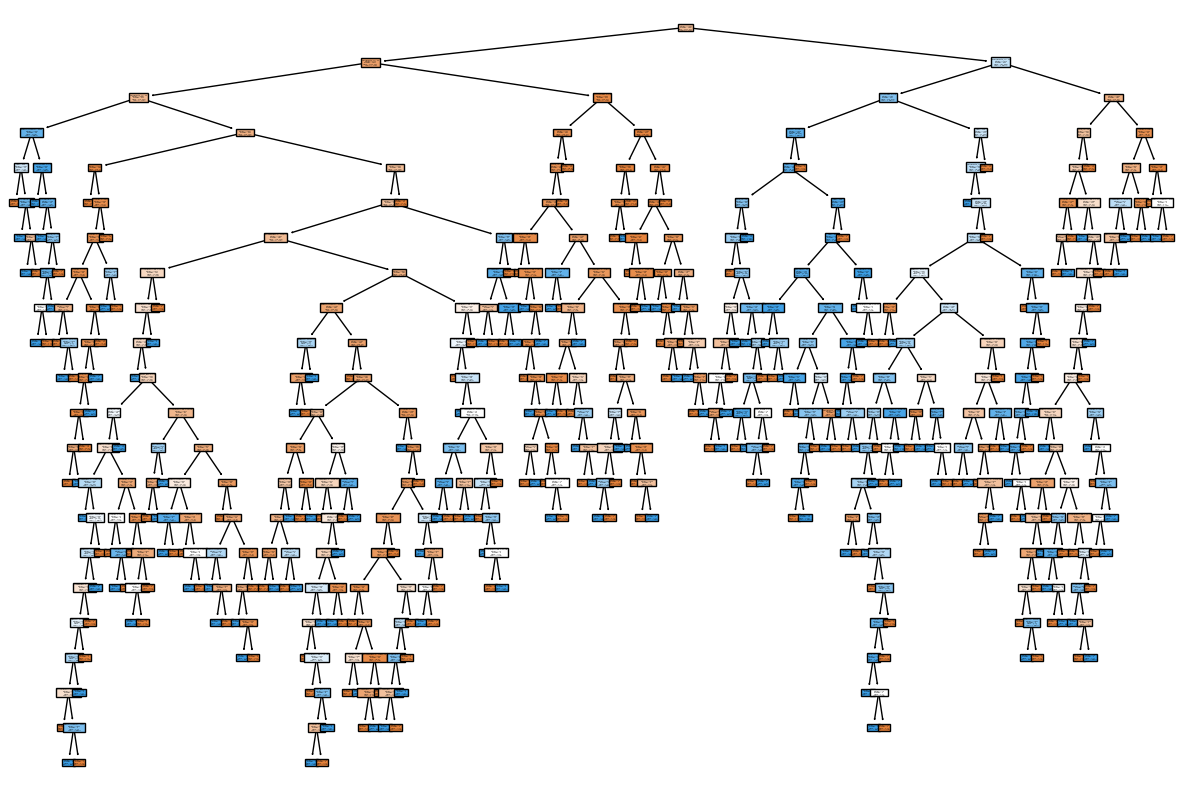

In [ ]:
#Построение графика дерева решений
fig = plt.figure(figsize=(15, 10))

tree_graph = tree.plot_tree(
    dt_clf_2d,
    feature_names=X.columns, 
    class_names=["0 - loyal", "1 - exited"],
    filled=True, 
);

> Исходя из показателей метрики и построения дерева на графике, можно сделать вывод, что модель получилась переобученной. Модель переобучилась, т.к. не была использована регуляризация - ограничение глубины дерева и кол-ва объектов на листьях.

In [141]:
#Обучение модели на тестовых данных
dt_clf_2d_test = dt_clf_2d
dt_clf_2d_test.fit(X_test, y_test)
#Предсказание
y_pred_test = dt_clf_2d_test.predict(X_test)
#Вывод метрик
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       424
           1       1.00      1.00      1.00       204

    accuracy                           1.00       628
   macro avg       1.00      1.00      1.00       628
weighted avg       1.00      1.00      1.00       628



> Вывод, который относился к тренировочным данным, так же относиться и к тестовым.

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [142]:
#Параметры модели леса
dt_clf_up = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=8,
    min_samples_leaf=10,
    random_state=42
)
#Обучение модели на тренировочных данных
dt_clf_up.fit(X_train, y_train)
#Обучение модели на тестовых данных
dt_clf_test_up = dt_clf_up
dt_clf_test_up.fit(X_test, y_test)

DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=10,
                       random_state=42)

In [143]:
#Предсказание на тренировочных данных
y_pred_train_up = dt_clf_up.predict(X_train)
#Вывод метрик
print(metrics.classification_report(y_train, y_pred_train_up))

#Предсказание на тестовых данных
y_pred_test_up = dt_clf_test_up.predict(X_test)
print(metrics.classification_report(y_test, y_pred_test_up))

              precision    recall  f1-score   support

           0       0.81      0.91      0.85      1271
           1       0.74      0.54      0.63       610

    accuracy                           0.79      1881
   macro avg       0.77      0.73      0.74      1881
weighted avg       0.78      0.79      0.78      1881

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       424
           1       0.81      0.62      0.70       204

    accuracy                           0.83       628
   macro avg       0.82      0.77      0.79       628
weighted avg       0.83      0.83      0.82       628



> Исходя из показателей метрик, можно заключить, что дерево недообучено, т.к. делает предсказание намного лучше на тренировочных данных, нежели на тестовых. Сравнивания две метрики, можно заметить, что модель обученная на тестовых данных, выдаёт чуть лучший результат. Ввод дополнительных параметров для регуляризации дерева, позволил избежать переобучения модели, но при этих параметрах, модель получилась недообученной. Хотя, исходя из задачи, показателя в 0.7 может быть достаточно.

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [144]:
from sklearn import ensemble #ансамбли

In [145]:
#Параметры модели случайного леса
rf_clf_2d = ensemble.RandomForestClassifier(
    n_estimators=600,
    max_depth=8,
    criterion='entropy',
    random_state = 42,
    min_samples_leaf=7
)

rf_clf_2d_test= rf_clf_2d
rf_clf_2d_train = rf_clf_2d
#Обучение моделей на тренировочных и тестовых данных
rf_clf_2d_train.fit(X_train, y_train)
rf_clf_2d_test.fit(X_test, y_test)

#Предсказание для тренировочных данных и вывод метрики
y_pred_rf_train = rf_clf_2d.predict(X_train)
print(metrics.classification_report(y_train, y_pred_rf_train))

#Предсказание для тестовых данных и вывод метрики
y_pred_rf_test = rf_clf_2d_test.predict(X_test)
print(metrics.classification_report(y_test, y_pred_rf_test))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1271
           1       0.77      0.55      0.65       610

    accuracy                           0.80      1881
   macro avg       0.79      0.74      0.75      1881
weighted avg       0.80      0.80      0.79      1881

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       424
           1       0.86      0.67      0.75       204

    accuracy                           0.86       628
   macro avg       0.86      0.81      0.82       628
weighted avg       0.86      0.86      0.85       628



> В сравнении с метрикой одного дерева, метрика слчайно леса показала на тестовых данных результат чуть лучше.


In [146]:
#Подключение библиотеки для подбора оптимальных параметров.
from sklearn.model_selection import GridSearchCV 

In [ ]:
#Подбор параметров для модели.
param_grid = {'n_estimators': [400, 500, 600, 700, 800, 900],
              'max_depth': [5,6,7,8, 9],
              'min_samples_split': [7,8,9,10,11]}
grid_search = GridSearchCV(rf_clf_2d, param_grid, cv=5)

# Обучаем модель на тренировочных данных
grid_search.fit(X_test, y_test)

# Выводим лучшие гиперпараметры и оценку качества модели
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'max_depth': 6, 'min_samples_split': 7, 'n_estimators': 800}
Best score:  0.7929650793650793


> Каждый раз получал разные параметры, но удалось подобрать более менее оптимальные.

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

c:\Users\dasad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dasad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


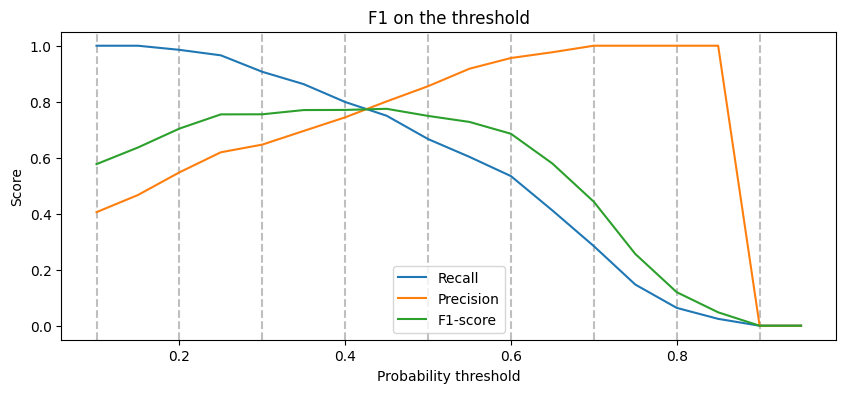

In [147]:
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(rf_clf_2d.predict_proba(X_test)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
recall_scores = []
precision_scores = []
f1_scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))
    
    #Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
for i in range(1, 10):
    ax.axvline(x=i/10, color='gray', linestyle='--', alpha=0.5)
ax.plot(thresholds, recall_scores, label='Recall')
ax.plot(thresholds, precision_scores, label='Precision')
ax.plot(thresholds, f1_scores, label='F1-score') 
ax.set_title('F1 on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend()
plt.show()

In [151]:
threshold_opt = 0.46

y_pred_rf_test = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
print(metrics.classification_report(y_test, y_pred_rf_test))



              precision    recall  f1-score   support

           0       0.88      0.92      0.90       424
           1       0.82      0.74      0.78       204

    accuracy                           0.86       628
   macro avg       0.85      0.83      0.84       628
weighted avg       0.86      0.86      0.86       628



> Исходя из графика можно заключить, что оптимальный показатель метрики находится в точке 0.45 - 0.46.


> Наилучший результат показала метрика случаного леса. После несколькоих попыток подобрать различные варианты параметров, удалось получить результаты метрики достаточно высокие на тестовой выборке с использованием случайного леса, нежели на метрике одного "подстриженного" дерева. Хотя в сравнении метрики отличаются не сильно.

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [158]:
new_data = pd.DataFrame({
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
})

new_data

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,601.0,Male,42.0,1,98495.72,1.0,1.0,0.0,40014.76


In [159]:
new_data['BalanceSalaryRatio'] = new_data['Balance']/new_data['EstimatedSalary']
new_data['TenureByAge'] = new_data['Age'] / new_data['Tenure']
new_data['CreditScoreGivenAge'] = new_data['CreditScore'] / new_data['Age']
new_data = pd.get_dummies( new_data, columns =['Gender'], dtype = 'int')
new_data = pd.get_dummies(new_data, columns = ['Tenure'], dtype  = 'int')
new_data = pd.get_dummies(new_data, columns = ['NumOfProducts'], dtype = 'int')


new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CreditScore          1 non-null      float64
 1   Age                  1 non-null      float64
 2   Balance              1 non-null      float64
 3   HasCrCard            1 non-null      float64
 4   IsActiveMember       1 non-null      float64
 5   EstimatedSalary      1 non-null      float64
 6   BalanceSalaryRatio   1 non-null      float64
 7   TenureByAge          1 non-null      float64
 8   CreditScoreGivenAge  1 non-null      float64
 9   Gender_Male          1 non-null      int32  
 10  Tenure_1             1 non-null      int32  
 11  NumOfProducts_1.0    1 non-null      int32  
dtypes: float64(9), int32(3)
memory usage: 216.0 bytes


In [160]:
#Удаление признаков, чтобы проще было создать нужную их последовательность в финальном сете.
new_data = new_data.drop(['Tenure_1', 'Gender_Male','NumOfProducts_1.0'], axis = 1)

In [161]:
#Получение списка признаков
X_test.columns

Index(['CreditScore', 'Age', 'Balance', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'BalanceSalaryRatio', 'TenureByAge',
       'CreditScoreGivenAge', 'Gender_Female', 'Gender_Male', 'Tenure_1',
       'Tenure_2', 'Tenure_3', 'Tenure_4', 'Tenure_5', 'Tenure_6', 'Tenure_7',
       'Tenure_8', 'Tenure_9', 'Tenure_10', 'NumOfProducts_1',
       'NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4'],
      dtype='object')

In [162]:
#Заполнение признаков
new_data = new_data.assign(Gender_Female = 0, Gender_Male= 1, Tenure_1 = 1,
       Tenure_2 = 0, Tenure_3 = 0, Tenure_4= 0, Tenure_5 = 0, Tenure_6 = 0, Tenure_7 = 0,
       Tenure_8 = 0, Tenure_9 = 0, Tenure_10 = 0, NumOfProducts_1 = 1,
       NumOfProducts_2 = 0, NumOfProducts_3 = 0, NumOfProducts_4 = 0)
new_data.columns

Index(['CreditScore', 'Age', 'Balance', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'BalanceSalaryRatio', 'TenureByAge',
       'CreditScoreGivenAge', 'Gender_Female', 'Gender_Male', 'Tenure_1',
       'Tenure_2', 'Tenure_3', 'Tenure_4', 'Tenure_5', 'Tenure_6', 'Tenure_7',
       'Tenure_8', 'Tenure_9', 'Tenure_10', 'NumOfProducts_1',
       'NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4'],
      dtype='object')

In [163]:
r_scaler = preprocessing.RobustScaler()
new_data_sc = r_scaler.fit_transform(new_data)
new_data_sc


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [164]:
#Проверка клиента на лояльность без использования коэффициента.
y_new_predict = rf_clf_2d.predict(new_data)
print('Predicted class: {}'.format(y_new_predict))


Predicted class: [1]


In [165]:
#Проверка клиента на лояльность с использованием коэффициента. 
prob = rf_clf_2d.predict(new_data)
print('Predicted class: {}'.format(y_new_predict))
predictions = [1 if prob > 0.46 else 0 for prob in prob]
print('Predicted class: {}'.format(predictions))

Predicted class: [1]
Predicted class: [1]


In [171]:
# предсказываем класс
data_pred = rf_clf_2d.predict_proba(new_data)
print(f'Вероятность оттока клиента: {round(data_pred[0][1]*100,2)}%')

Вероятность оттока клиента: 62.72%


> Не стал делать полиномиальные признаки, т.к. выше было указано, что смысла в данной модели от них не много.
> Предсказание класса клиента Василия причислило его к не лояльным клиентам. Из чего руководство может заключить, что на него можно потратить дополнительные средства, чтобы попытаться его удержать в качестве клиента.